In [2]:
import importlib
from SpLSI import generate_topic_model as gen_model
from SpLSI import utils 
from SpLSI import splsi_
import numpy as np
import pandas as pd
import networkx as nx
import community as community_louvain  
from sklearn.metrics.pairwise import euclidean_distances
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from types import SimpleNamespace
import time
import statistics
import contextlib
import random
import os
import sys
import warnings
import community as community_louvain  

/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects import pandas2ri
from rpy2.robjects import numpy2ri

In [4]:
importlib.reload(gen_model)
importlib.reload(splsi_)
importlib.reload(utils)

<module 'SpLSI.utils' from '/Users/zhangzeyu/Downloads/research/SpLSI/SpLSI/utils.py'>

In [46]:
def simulation_spectral(k=4, iteration=10, sct_transform=True, maxiter=50):
    acc_spectral = []
    time_spectral = []
    acc_pca = []

    for i in range(iteration):
        random.seed(123+i)
        coords_df = gen_model.generate_graph(100, 1000, 30, k, 0.05)
        W = gen_model.generate_W_strong(coords_df, 100, 1000, 30, k, 0.05) 
        L = np.diag(np.random.rand(min(W.shape)))
        V, _ = np.linalg.qr(np.random.randn(30, W.shape[0])) # fix p = 30
        X = W.T @ L @ V.T
        # X = X + np.random.normal(0, 0.02, X.shape)
        X = utils.euclidean_proj_simplex(X, s=1)
        X = utils.multinomial_from_rows(X,n=100)

        if sct_transform:
            numpy2ri.activate()
            pandas2ri.activate()
            seurat = rpackages.importr('Seurat')

            r_X_T = numpy2ri.py2rpy(X.T)
            robjects.globalenv['counts_matrix'] = r_X_T

            robjects.r('''
                library(Seurat)
                seurat_obj <- CreateSeuratObject(counts = as.matrix(counts_matrix))
                seurat_obj <- SCTransform(seurat_obj, verbose = FALSE)
                normalized_matrix <- as.data.frame(GetAssayData(seurat_obj, layer = "data", assay = "SCT"))
            ''')

            normalized_df = pandas2ri.rpy2py(robjects.globalenv['normalized_matrix'])
            X = normalized_df.to_numpy().T
            X = X - np.mean(X, axis=0)
        else:
            pass

        ### SpatialSVD and Regular PCA
        weights, edge_df = gen_model.generate_weights_edge(coords_df, 4, 0.05)
        start_time_1 = time.time()
        model_hooi = splsi_.SpLSI_(lamb_start=0.001,maxiter=maxiter,step_size=1.2,grid_len=29,method="hooi",verbose=0,eps=1e-05,normalize=True,L_inv_=True)
        model_hooi.fit(X, k, edge_df, weights)
        end_time_1 = time.time()
        running_time_1 = end_time_1 - start_time_1

        U = model_hooi.U
        V_hat = model_hooi.V
        acc_spectral.append(utils.group_and_compare_spectral(U, coords_df))
        time_spectral.append(running_time_1)
        U_svd, _, _ = svds(X.astype(float), k=k)
        acc_pca.append(utils.group_and_compare_spectral(U_svd, coords_df))

    return SimpleNamespace(acc_spectral=statistics.mean(acc_spectral), time_spectral=statistics.mean(time_spectral), acc_pca=statistics.mean(acc_pca), acc_list = acc_spectral, time_list= time_spectral)



In [6]:
def simulation_bayes(k=4, iteration=10):
    acc_bayes = []
    time_bayes = []

    for i in range(iteration):
        random.seed(123+i)
        coords_df = gen_model.generate_graph(100, 1000, 30, k, 0.05)
        W = gen_model.generate_W_strong(coords_df, 100, 1000, 30, k, 0.05) 
        L = np.diag(np.random.rand(min(W.shape)))
        V, _ = np.linalg.qr(np.random.randn(30, W.shape[0])) # fix p = 30
        X = W.T @ L @ V.T
        # X = X + np.random.normal(0, 0.02, X.shape)
        X = utils.euclidean_proj_simplex(X, s=1)
        X = utils.multinomial_from_rows(X,n=100)



        robjects.globalenv['k'] = k

        ### BayesSpace
        pandas2ri.activate()
        numpy2ri.activate()
        SingleCellExperiment = rpackages.importr('SingleCellExperiment')
        BayesSpace = rpackages.importr('BayesSpace')

        coords_df_r = coords_df.iloc[:, :2]
        coords_df_r.columns = ['row', 'col']
        location_df_r = pandas2ri.py2rpy(coords_df_r)

        robjects.globalenv['counts_matrix'] = X.T 
        robjects.globalenv['location_df'] = location_df_r

        start_time_2 = time.time()
        robjects.r('''
        rownames(counts_matrix) <- 1:nrow(counts_matrix)
        colnames(counts_matrix) <- 1:ncol(counts_matrix)
        rownames(location_df) <- 1:ncol(counts_matrix)

        sce <- SingleCellExperiment(
        assays = list(counts = counts_matrix),
        colData = location_df
        )

        sce <- spatialPreprocess(sce, platform = "ST", 
                                n.PCs = k, n.HVGs = 2000, log.normalize = TRUE)

        sce <- spatialCluster(sce, q = 4, platform = "ST", d = 7,
                            init.method = "mclust", model = "t", gamma = 2,
                            nrep = 10000, burn.in = 100, save.chain = TRUE)
        ''')
        end_time_2 = time.time()
        running_time_2 = end_time_2 - start_time_2
        time_bayes.append(running_time_2)

        clusters = robjects.r('sce$spatial.cluster')
        acc_bayes.append(utils.get_accuracy(clusters-1, coords_df))

    return SimpleNamespace(acc_bayes=statistics.mean(acc_bayes), time_bayes=statistics.mean(time_bayes))

In [7]:
def simulation_spatial(k=4, iteration=10):
    acc_spatial = []
    time_spatial = []

    i = 0
    while i < iteration:
        try:
            random.seed(123 + i)
            coords_df = gen_model.generate_graph(100, 1000, 30, k, 0.05)
            W = gen_model.generate_W_strong(coords_df, 100, 1000, 30, k, 0.05)
            L = np.diag(np.random.rand(min(W.shape)))
            V, _ = np.linalg.qr(np.random.randn(30, W.shape[0]))  # fix p = 30
            X = W.T @ L @ V.T
            X = utils.euclidean_proj_simplex(X, s=1)
            X = utils.multinomial_from_rows(X, n=100)

            robjects.globalenv['k'] = k
            pandas2ri.activate()
            numpy2ri.activate()

            ### SpatialPCA
            counts = X.T  
            location = coords_df.iloc[:, :2].to_numpy()  

            counts_r = numpy2ri.py2rpy(counts)
            location_r = numpy2ri.py2rpy(location)
            robjects.globalenv['counts_r'] = counts_r
            robjects.globalenv['location_r'] = location_r

            robjects.r('rownames(counts_r) <- 1:nrow(counts_r)')
            robjects.r('colnames(counts_r) <- 1:ncol(counts_r)')
            robjects.r('rownames(location_r) <- 1:nrow(location_r)')

            start_time_3 = time.time()
            robjects.r('''
            library(SpatialPCA)

            ST <- CreateSpatialPCAObject(counts = counts_r,
                location = location_r,
                project = "SpatialPCA",
                gene.type = "spatial",
                sparkversion = "spark",
                min.loctions = 2,
                min.features = 10
            )

            ST <- SpatialPCA_buildKernel(
                ST,
                kerneltype = "gaussian",
                bandwidthtype = "SJ"
            )

            ST <- SpatialPCA_EstimateLoading(
                ST,
                fast = FALSE,
                SpatialPCnum = k
            )

            ST <- SpatialPCA_SpatialPCs(
                ST,
                fast = FALSE
            )
            ''')
            end_time_3 = time.time()
            running_time_3 = end_time_3 - start_time_3
            time_spatial.append(running_time_3)

            SpatialPC = robjects.r('ST@SpatialPCs')
            acc_spatial.append(utils.group_and_compare_spectral(SpatialPC.T, coords_df))

            # Increment the iteration only when successful
            i += 1

        except Exception as e:
            print(f"Error in iteration {i}: {e}")
            print("Retrying the current iteration...")
            continue  # Restart the same iteration

    return SimpleNamespace(acc_spatial=statistics.mean(acc_spatial), time_spatial=statistics.mean(time_spatial), acc_list=acc_spatial, time_list=time_spatial)




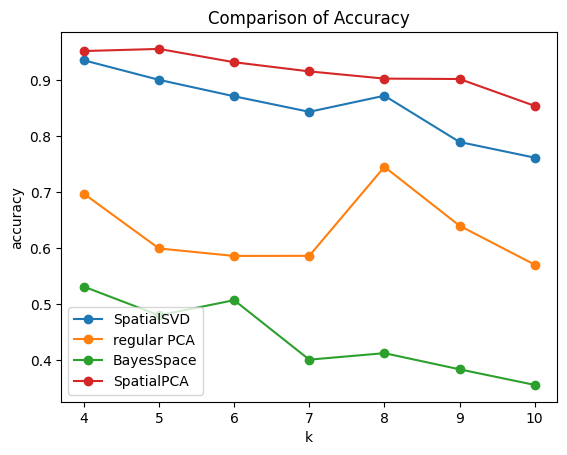

In [89]:
# results_spectral = [result_spectral_4, result_spectral_5, result_spectral_6, result_spectral_7, result_spectral_8, result_spectral_9, result_spectral_10]
results_spectral_1 = [result_spectral_4_1, result_spectral_5_1, result_spectral_6_1, result_spectral_7_1, result_spectral_8_1, result_spectral_9_1, result_spectral_10_1]
results_bayes = [result_bayes_4, result_bayes_5, result_bayes_6, result_bayes_7, result_bayes_8, result_bayes_9, result_bayes_10]
results_spatial = [result_spatial_4, result_spatial_5, result_spatial_6, result_spatial_7, result_spatial_8, result_spatial_9, result_spatial_10]

# plt.plot(range(4, 11), [result.acc_spectral for result in results_spectral], marker='o', label='SpatialSVD with no transformation')
plt.plot(range(4, 11), [result.acc_spectral for result in results_spectral_1], marker='o', label='SpatialSVD')
plt.plot(range(4, 11), [result.acc_pca for result in results_spectral_1], marker='o', label='regular PCA')
plt.plot(range(4, 11), [result.acc_bayes for result in results_bayes], marker='o', label='BayesSpace')
plt.plot(range(4, 11), [result.acc_spatial for result in results_spatial], marker='o', label='SpatialPCA')

plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('Comparison of Accuracy')
plt.legend()
plt.show()

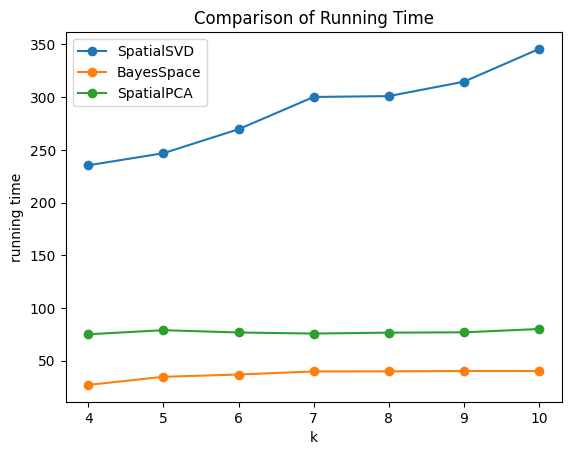

In [90]:
plt.plot(range(4, 11), [result.time_spectral for result in results_spectral_1], marker='o', label='SpatialSVD')
# plt.plot(range(4, 11), [result.time_spectral for result in results_spectral], marker='o', label='SpatialSVD with no transformation')
plt.plot(range(4, 11), [result.time_bayes for result in results_bayes], marker='o', label='BayesSpace')
plt.plot(range(4, 11), [result.time_spatial for result in results_spatial], marker='o', label='SpatialPCA')

plt.xlabel('k')
plt.ylabel('running time')
plt.title('Comparison of Running Time')
plt.legend()
plt.show()

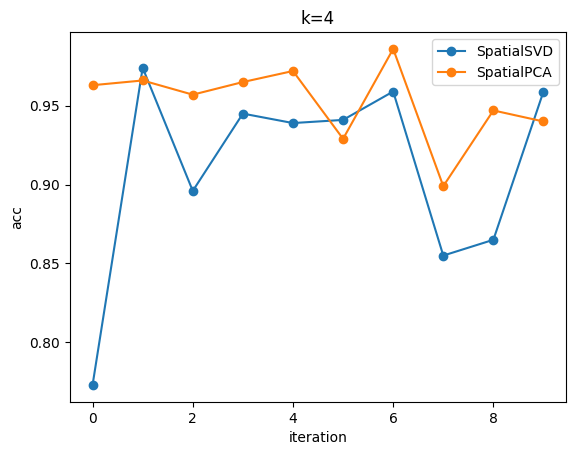

In [41]:
plt.plot(range(10), result_spectral_4_1.acc_list, marker='o', label='SpatialSVD')
plt.plot(range(10), result_spatial_4.acc_list, marker='o', label='SpatialPCA')

plt.xlabel('iteration')
plt.ylabel('acc')
plt.title('k=4')
plt.legend()
plt.show()

In [ ]:
coords_df_6 = gen_model.generate_graph(100, 2000, 30, 6, 0.05)
W_4 = gen_model.generate_W_strong(coords_df_6, 100, 2000, 30, 6, 0.05) 


In [117]:
from scipy.linalg import inv, sqrtm

p = 30   
k = 6   
m = 20  
l =6

V1 = np.zeros((p, k))
V1[0:m, 0:l] = np.random.uniform(0, 1, (m, l))

U_tilde = V1[0:m, 0:l]
U_hat = U_tilde @ sqrtm(inv(U_tilde.T @ U_tilde))
V1[0:m, 0:l] = U_hat

V2 = np.random.uniform(0, 1, (p, p-k))
V2 = V2 - (V1 @ V1.T @ V2)
V2 = V2 @ sqrtm(inv(V2.T @ V2))

V_combined = np.hstack((V1, V2))

# Verify that (V1, V2)^T (V1, V2) is approximately the identity matrix
identity_check = V_combined.T @ V_combined
tolerance = 1e-10
if np.allclose(identity_check, np.eye(p), atol=tolerance):
    print("close to the identity matrix")
else:
    print("not close to the identity matrix.")

np.diag(identity_check)

close to the identity matrix


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

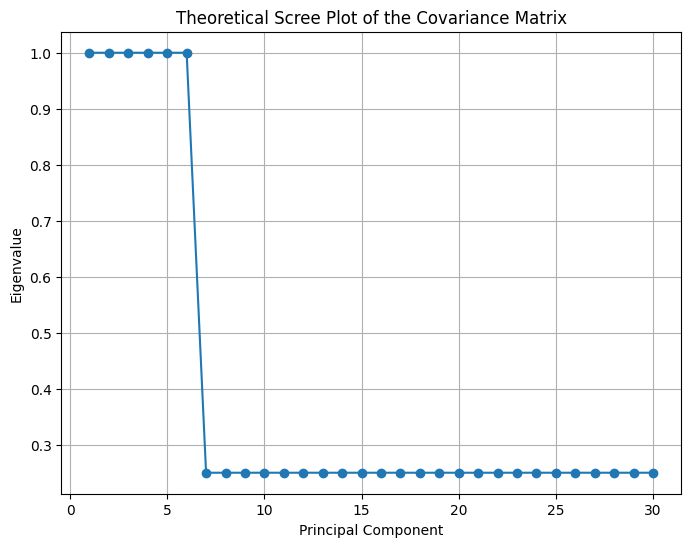

In [118]:
alpha = 1.0  
delta = 0.5  
Lambda1 = np.diag([alpha] * k)
Lambda2 = np.diag([alpha - delta] * (p - k))
Lambda = np.block([[Lambda1, np.zeros((k, p - k))],
                   [np.zeros((p - k, k)), Lambda2]])

Sigma_squared = Lambda @ Lambda
cov_matrix_theoretical = V_combined @ Sigma_squared @ V_combined.T

eigenvalues = np.linalg.eigvalsh(cov_matrix_theoretical)

sorted_eigenvalues = np.sort(eigenvalues)[::-1]

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(sorted_eigenvalues) + 1), sorted_eigenvalues, marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue")
plt.title("Theoretical Scree Plot of the Covariance Matrix")
plt.grid()
plt.show()

## K = 4

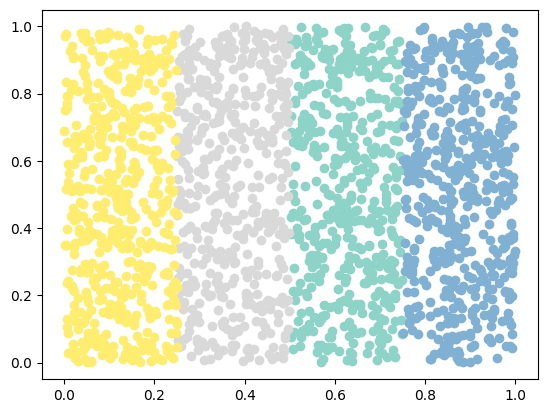

In [59]:
coords_df_4 = gen_model.generate_graph(100, 2000, 30, 4, 0.05)
gen_model.plot_scatter(coords_df_4)
W_4 = gen_model.generate_W_strong(coords_df_4, 100, 2000, 30, 4, 0.05) 
L_4 = np.diag(np.random.rand(min(W_4.shape)))
V_4, _ = np.linalg.qr(np.random.randn(30, W_4.shape[0])) # fix p = 30
X_4 = W_4.T @ L_4 @ V_4.T
# X_4 = X_4 + np.random.normal(0, 0.02, X_4.shape)
X_4 = utils.euclidean_proj_simplex(X_4, s=1)
X_4 = utils.multinomial_from_rows(X_4,n=100)

In [61]:

numpy2ri.activate()
pandas2ri.activate()


seurat = rpackages.importr('Seurat')

r_X_T = numpy2ri.py2rpy(X_4.T)
robjects.globalenv['counts_matrix'] = r_X_T

robjects.r('''
    library(Seurat)
    seurat_obj <- CreateSeuratObject(counts = as.matrix(counts_matrix))
    seurat_obj <- SCTransform(seurat_obj, verbose = FALSE)
    normalized_matrix <- as.data.frame(GetAssayData(seurat_obj, layer = "data", assay = "SCT"))
''')

normalized_df = pandas2ri.rpy2py(robjects.globalenv['normalized_matrix'])
X_4 = normalized_df.to_numpy().T

R[write to console]: Warning:
R[write to console]:  Data is of class matrix. Coercing to dgCMatrix.



In [62]:
weights_4, edge_df_4 = gen_model.generate_weights_edge(coords_df_4, 4, 0.05)
model_hooi_4 = splsi_.SpLSI_(lamb_start=0.001,step_size=1.2,grid_len=29,method="hooi",verbose=0,eps=1e-05,normalize=True,L_inv_=True)
model_hooi_4.fit(X_4, 4, edge_df_4, weights_4)

Running spatial HOSVD...
Initializing..


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Optimal lambda is 0.038443359375...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxclu

Normalizing...
Optimal lambda is 0.06624737266949231...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxclu

Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
SpatialSVD ran for 14 steps.
Running SPOC...


In [63]:
U_4 = model_hooi_4.U
V_hat_4 = model_hooi_4.V

In [64]:
acc_4_spectral = utils.group_and_compare_spectral(U_4, coords_df_4)
print(f"Clustering Accuracy for Spatial PCA: {acc_4_spectral:.2f}")
U_44, _, _ = svds(X_4.astype(float), k=4)
acc_4_pca_spectral = utils.group_and_compare_spectral(U_44, coords_df_4)
print(f"Clustering Accuracy for regular PCA: {acc_4_pca_spectral:.2f}")

Clustering Accuracy for Spatial PCA: 0.94
Clustering Accuracy for regular PCA: 0.62


In [60]:

counts = X_4.T  # Transpose counts matrix as required
location = coords_df_4.iloc[:, :2].to_numpy()  # Extract the first two columns for coordinates

counts_r = numpy2ri.py2rpy(counts)
location_r = numpy2ri.py2rpy(location)
robjects.globalenv['counts_r'] = counts_r
robjects.globalenv['location_r'] = location_r

robjects.r('rownames(counts_r) <- 1:nrow(counts_r)')
robjects.r('colnames(counts_r) <- 1:ncol(counts_r)')
robjects.r('rownames(location_r) <- 1:nrow(location_r)')

robjects.r('''
library(SpatialPCA)

ST <- CreateSpatialPCAObject(
    counts = counts_r,
    location = location_r,
    project = "SpatialPCA",
    gene.type = "spatial",
    sparkversion = "spark",
    min.loctions = 2,
    min.features = 10
)

# 2. Build the kernel with Gaussian type
ST <- SpatialPCA_buildKernel(
    ST,
    kerneltype = "gaussian",
    bandwidthtype = "SJ"
)

# 3. Estimate loadings
ST <- SpatialPCA_EstimateLoading(
    ST,
    fast = FALSE,
    SpatialPCnum = 4
)

# 4. Perform SpatialPCA
ST <- SpatialPCA_SpatialPCs(
    ST,
    fast = FALSE
)
''')

SpatialPC = robjects.r('ST@SpatialPCs')
print(utils.group_and_compare_spectral(SpatialPC.T, coords_df_4))

R[write to console]: Warning:
R[write to console]:  Data is of class matrix. Coercing to dgCMatrix.



## Use SCTransform function in Seurat to normalize data. 


R[write to console]: Running SCTransform on assay: RNA

R[write to console]: Running SCTransform on layer: counts

R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Variance stabilizing transformation of count matrix of size 30 by 2000

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 16 genes, 2000 cells

R[write to console]: Second step: Get residuals using fitted parameters for 30 genes

R[write to console]: Computing corrected count matrix for 30 genes

R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.760438 secs

R[write to console]: Determine variable features

R[write to console]: Centering data matrix

  |                                                                            
  |                                                             

## Use spark.test function in SPARK package to select spatially variable genes. 
## ===== SPARK INPUT INFORMATION ==== 
## number of total samples:  2000 
## number of total features:  30 
## number of adjusted covariates:  0 
# fitting normalized count-based spatial model under the null hypothesis ... 
## testing Gaussian kernel: 1...
## testing Periodic kernel: 1...
## testing Gaussian kernel: 2...
## testing Periodic kernel: 2...
## testing Gaussian kernel: 3...
## testing Periodic kernel: 3...
## testing Gaussian kernel: 4...
## testing Periodic kernel: 4...
## testing Gaussian kernel: 5...
## testing Periodic kernel: 5...
## Identified  23  spatial genes through spark.test function. 
The  number of significant spatial genes is less than the specified number of spatial genes. 
## Using  23  significant spatially variable genes. 
## Selected kernel type is:  gaussian  
## The bandwidth is:  0.153955865234698  
## Calculating kernel matrix
## Finished calculating kernel matrix.
[1] "

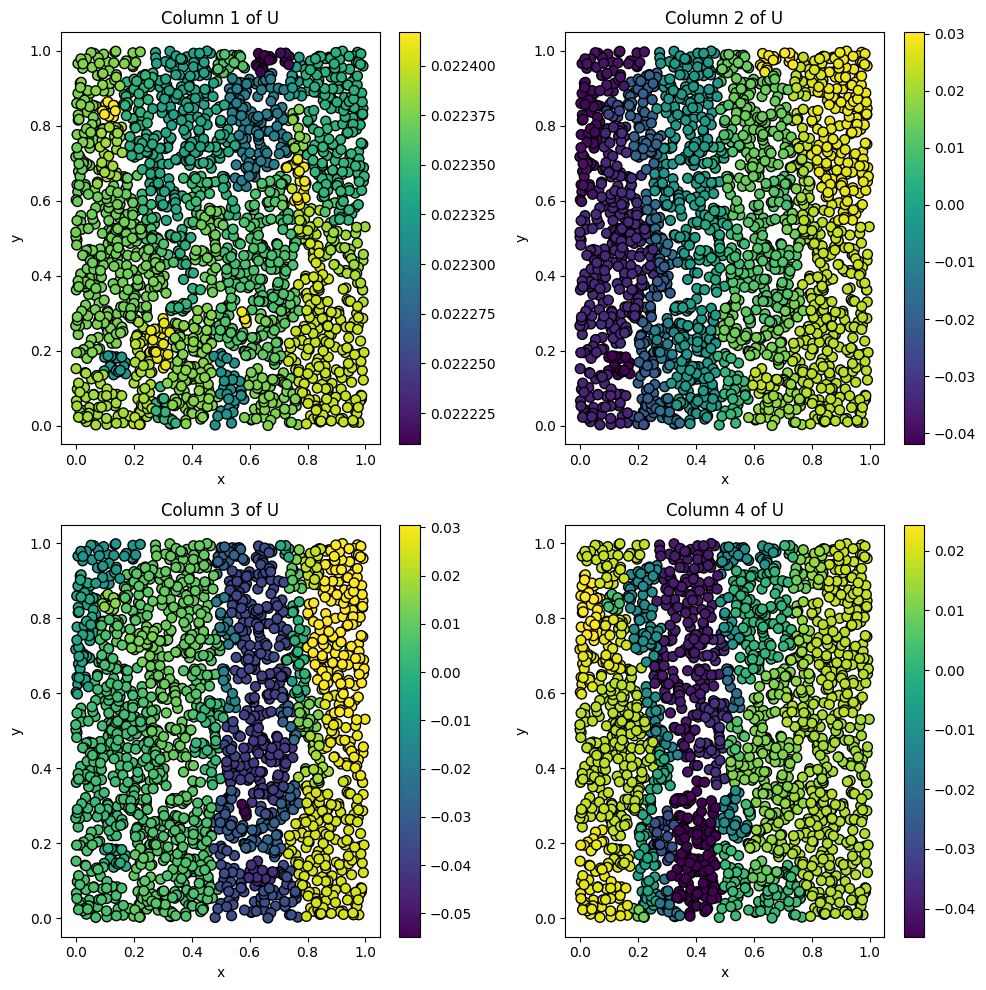

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes = axes.flatten()

for i in range(4):
    sc = axes[i].scatter(coords_df_4['x'], coords_df_4['y'], c=U_4[:, i], cmap='viridis', s=50, edgecolor='k')
    axes[i].set_title(f'Column {i + 1} of U')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    plt.colorbar(sc, ax=axes[i], orientation='vertical')

plt.tight_layout()
plt.show()

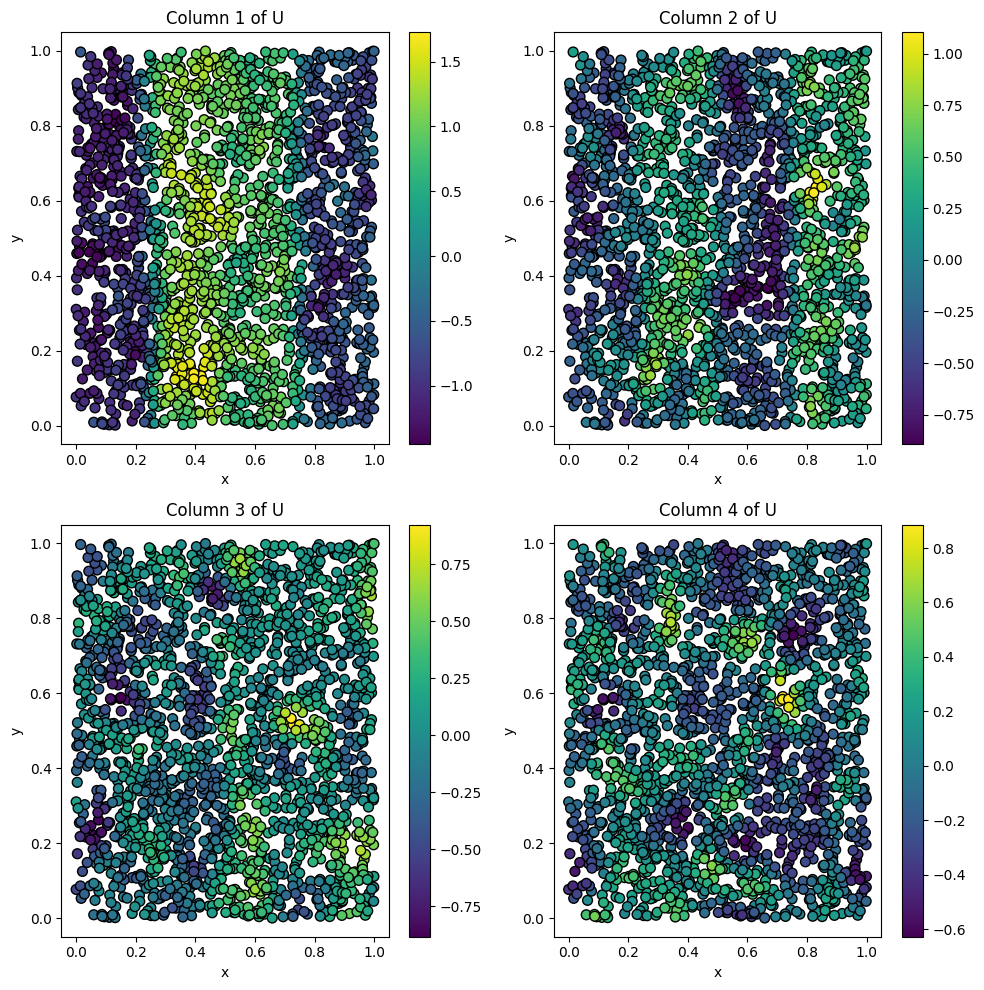

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes = axes.flatten()

for i in range(4):
    sc = axes[i].scatter(coords_df_4['x'], coords_df_4['y'], c=SpatialPC.T[:, i], cmap='viridis', s=50, edgecolor='k')
    axes[i].set_title(f'Column {i + 1} of U')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    plt.colorbar(sc, ax=axes[i], orientation='vertical')

plt.tight_layout()
plt.show()

In [ ]:
result_bayes_4 = simulation_bayes(k=4, iteration=10)
result_bayes_5 = simulation_bayes(k=5, iteration=10)
result_bayes_6 = simulation_bayes(k=6, iteration=10)
result_bayes_7 = simulation_bayes(k=7, iteration=10)
result_bayes_8 = simulation_bayes(k=8, iteration=10)
result_bayes_9 = simulation_bayes(k=9, iteration=10)
result_bayes_10 = simulation_bayes(k=10, iteration=10)

In [ ]:
result_spatial_4 = simulation_spatial(k=4, iteration=10)
result_spatial_5 = simulation_spatial(k=5, iteration=10)
result_spatial_6 = simulation_spatial(k=6, iteration=10)

In [ ]:
result_spatial_7 = simulation_spatial(k=7, iteration=10)
result_spatial_8 = simulation_spatial(k=8, iteration=10)
result_spatial_9 = simulation_spatial(k=9, iteration=10)
result_spatial_10 = simulation_spatial(k=10, iteration=10)

In [ ]:
result_spectral_4_1 = simulation_spectral(k=4, iteration=10, sct_transform=True)

In [ ]:
result_spectral_5_1 = simulation_spectral(k=5, iteration=10, sct_transform=True)
result_spectral_6_1 = simulation_spectral(k=6, iteration=10, sct_transform=True)
result_spectral_7_1 = simulation_spectral(k=7, iteration=10, sct_transform=True)
result_spectral_8_1 = simulation_spectral(k=8, iteration=10, sct_transform=True)

In [ ]:
result_spectral_9_1 = simulation_spectral(k=9, iteration=10, sct_transform=True)
result_spectral_10_1 = simulation_spectral(k=10, iteration=10, sct_transform=True)

In [47]:
result_spectral_4_1 = simulation_spectral(k=4, iteration=15, sct_transform=True, maxiter=10)

R[write to console]: Warning:
R[write to console]:  Data is of class matrix. Coercing to dgCMatrix.



Running spatial HOSVD...
Initializing..


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Optimal lambda is 0.038443359375...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxclu

Normalizing...
Optimal lambda is 0.0552061438912436...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.09539621664406893...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
SpatialSVD ran for 10 steps.
Running SPOC...


R[write to console]: Warning:
R[write to console]:  Data is of class matrix. Coercing to dgCMatrix.



Running spatial HOSVD...
Initializing..


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Optimal lambda is 0.038443359375...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxclu

Normalizing...
Optimal lambda is 0.06624737266949231...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.09539621664406893...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.09539621664406893...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.09539621664406893...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.09539621664406893...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.09539621664406893...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.09539621664406893...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.09539621664406893...
SpatialSVD ran for 10 steps.
Running SPOC...


R[write to console]: Warning:
R[write to console]:  Data is of class matrix. Coercing to dgCMatrix.



Running spatial HOSVD...
Initializing..


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Optimal lambda is 0.038443359375...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxclu

Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxclu

Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
SpatialSVD ran for 10 steps.
Running SPOC...


R[write to console]: Warning:
R[write to console]:  Data is of class matrix. Coercing to dgCMatrix.



Running spatial HOSVD...
Initializing..


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Optimal lambda is 0.038443359375...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxclu

Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
SpatialSVD ran for 10 steps.
Running SPOC...


R[write to console]: Warning:
R[write to console]:  Data is of class matrix. Coercing to dgCMatrix.



Running spatial HOSVD...
Initializing..


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Optimal lambda is 0.038443359375...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
SpatialSVD ran for 10 steps.
Running SPOC...


R[write to console]: Warning:
R[write to console]:  Data is of class matrix. Coercing to dgCMatrix.



Running spatial HOSVD...
Initializing..


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Optimal lambda is 0.038443359375...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxclu

Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxclu

Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
SpatialSVD ran for 10 steps.
Running SPOC...


R[write to console]: Warning:
R[write to console]:  Data is of class matrix. Coercing to dgCMatrix.



Running spatial HOSVD...
Initializing..


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Optimal lambda is 0.038443359375...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxclu

Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.09539621664406893...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.09539621664406893...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
SpatialSVD ran for 10 steps.
Running SPOC...


R[write to console]: Warning:
R[write to console]:  Data is of class matrix. Coercing to dgCMatrix.



Running spatial HOSVD...
Initializing..


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Optimal lambda is 0.038443359375...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxclu

Normalizing...
Optimal lambda is 0.09539621664406893...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
SpatialSVD ran for 10 steps.
Running SPOC...


R[write to console]: Warning:
R[write to console]:  Data is of class matrix. Coercing to dgCMatrix.



Running spatial HOSVD...
Initializing..


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Optimal lambda is 0.038443359375...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxclu

Normalizing...
Optimal lambda is 0.0552061438912436...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.09539621664406893...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.09539621664406893...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
SpatialSVD ran for 10 steps.
Running SPOC...


R[write to console]: Warning:
R[write to console]:  Data is of class matrix. Coercing to dgCMatrix.



Running spatial HOSVD...
Initializing..


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Optimal lambda is 0.038443359375...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxclu

Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
SpatialSVD ran for 10 steps.
Running SPOC...


R[write to console]: Warning:
R[write to console]:  Data is of class matrix. Coercing to dgCMatrix.



Running spatial HOSVD...
Initializing..


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Optimal lambda is 0.038443359375...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxclu

Normalizing...
Optimal lambda is 0.06624737266949231...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.09539621664406893...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
SpatialSVD ran for 10 steps.
Running SPOC...


R[write to console]: Warning:
R[write to console]:  Data is of class matrix. Coercing to dgCMatrix.



Running spatial HOSVD...
Initializing..


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Optimal lambda is 0.038443359375...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxclu

Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
SpatialSVD ran for 10 steps.
Running SPOC...


R[write to console]: Warning:
R[write to console]:  Data is of class matrix. Coercing to dgCMatrix.



Running spatial HOSVD...
Initializing..


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Optimal lambda is 0.038443359375...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxclu

Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxclu

Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.13737055196745926...
SpatialSVD ran for 10 steps.
Running SPOC...


R[write to console]: Warning:
R[write to console]:  Data is of class matrix. Coercing to dgCMatrix.



Running spatial HOSVD...
Initializing..


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Optimal lambda is 0.038443359375...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxclu

Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
SpatialSVD ran for 10 steps.
Running SPOC...


R[write to console]: Warning:
R[write to console]:  Data is of class matrix. Coercing to dgCMatrix.



Running spatial HOSVD...
Initializing..


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Optimal lambda is 0.038443359375...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.06624737266949231...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.1144754599728827...
SpatialSVD ran for 10 steps.
Running SPOC...
